In [72]:
from data_processing import get_data
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers import Input, LSTM, Dense, concatenate
from keras import Model, optimizers, losses, metrics
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [73]:
normal_data, abnormal_data, real_abnormal_data, real_abnormal_data_2 = get_data("rouen")

Normal data shape: (11884, 125)
Abnormal data shape: (300, 125)
Real abnormal data shape: (234, 125)
Real abnormal data 2 shape: (234, 125)


In [74]:
data = np.concatenate([normal_data, abnormal_data, real_abnormal_data, real_abnormal_data_2])
data.shape

(12652, 125)

In [75]:
db = DBSCAN(eps=0.2).fit(data)
labels_cluster = db.labels_
labels_cluster = np.reshape(labels_cluster, [-1, 1])
labels_cluster.shape

(12652, 1)

In [76]:
labels_cluster[labels_cluster != -1] = 1
labels_cluster[labels_cluster == -1] = 0

In [77]:
# Create the labels, since we will be doing supervised learning. 1 represents a normal trajectory, 0 is abnormal
labels = np.concatenate([
    np.ones(normal_data.shape[0]),
    np.zeros(abnormal_data.shape[0]),
    np.zeros(real_abnormal_data.shape[0]),
    np.zeros(real_abnormal_data_2.shape[0])
], 0)

labels = np.reshape(labels, [-1, 1])
labels.shape

(12652, 1)

In [78]:
# Let's see the distribution of normal and abnormal data
neg, pos = tf.math.bincount(labels_cluster)
total = neg + pos
print('Examples:\n    Total: {}\n    Normal: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 12652
    Normal: 8657 (68.42% of total)



In [79]:
# Let's see the distribution of normal and abnormal data
neg, pos = tf.math.bincount(labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Normal: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 12652
    Normal: 11884 (93.93% of total)



In [80]:
diff = labels - labels_cluster
correct_normal = len(diff[(diff == 0) & (labels == 1)]) * 100 / pos
correct_abnormal = len(diff[(diff == 0) & (labels == 0)]) * 100 / neg
print(f"Normal accuracy: {correct_normal:.2f}")
print(f"Abnormal accuracy: {correct_abnormal:.2f}")
print(f"Mean accuracy: {(correct_normal + correct_abnormal) / 2:.2f}")
# print(f"Misclassified normal: {false_neg}")
# print(f"Misclassified abnormal: {false_pos}")
# print(f"Accuracy: {correct * 100 / len(labels):.2f}%")

Normal accuracy: 70.91
Abnormal accuracy: 70.05
Mean accuracy: 70.48


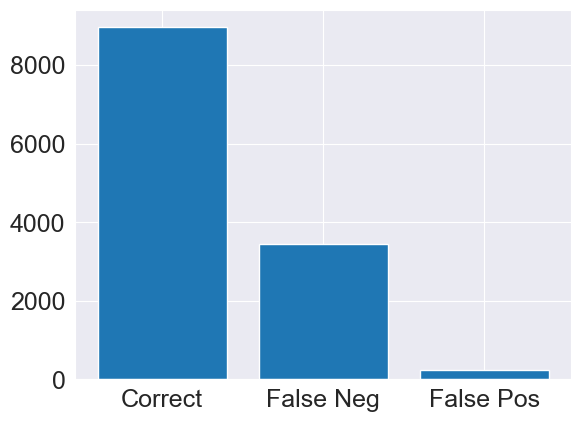

In [81]:
correct = len(diff[diff == 0])
false_neg = len(diff[diff == 1])
false_pos = len(diff[diff == -1])

plt.rcParams.update({'font.size': 18})
# plt.xticks([0, 1])
plt.bar(["Correct", "False Neg", "False Pos"], [correct, false_neg, false_pos])
plt.show()

In [82]:
data = np.concatenate([data, labels_cluster, labels], 1)
data.shape

(12652, 127)

In [83]:
train_data, test_data = train_test_split(data, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

In [84]:
train_labels = train_data[:,-2].astype('int32')
train_categories = train_data[:,0].astype('int32')
train_data = train_data[:,1:-2]

val_labels = val_data[:,-1].astype('int32')
val_categories = val_data[:,0].astype('int32')
val_data = val_data[:,1:-2]

test_labels = test_data[:,-1].astype('int32')
test_categories = test_data[:,0].astype('int32')
test_data = test_data[:,1:-2]

In [85]:
print(train_labels.shape)
print(train_categories.shape)
print(train_data.shape)

(8096,)
(8096,)
(8096, 124)


In [86]:
# The category data needs to be one-hot encoded
train_categories = np.reshape(train_categories, newshape=[-1, 1])
val_categories = np.reshape(val_categories, newshape=[-1, 1])
test_categories = np.reshape(test_categories, newshape=[-1, 1])

one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(train_categories)
one_hot_encoder.fit(val_categories)
one_hot_encoder.fit(test_categories)

train_categories = one_hot_encoder.transform(train_categories)
val_categories = one_hot_encoder.transform(val_categories)
test_categories = one_hot_encoder.transform(test_categories)

In [87]:
train_categories.shape

(8096, 2)

In [88]:
# The trajectory data however needs to be reshaped into data containing 31 timesteps for 4 features.
# The trajectory features are the x and y location, and the x and y velocities over 31 timesteps

features = 4
timesteps = int(train_data.shape[1] / features)

train_data = np.transpose(np.reshape(train_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])
val_data = np.transpose(np.reshape(val_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])
test_data = np.transpose(np.reshape(test_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])

train_data.shape

(8096, 4, 31)

In [89]:
train_labels.shape

(8096,)

In [90]:
bool_train_labels = train_labels != 0

pos_features = train_data[bool_train_labels]
neg_features = train_data[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

pos_categories = train_categories[bool_train_labels]
neg_categories = train_categories[~bool_train_labels]

In [91]:
ids = np.arange(len(neg_features))
choices = np.random.choice(ids, len(pos_features))

res_neg_features = neg_features[choices]
res_neg_labels = neg_labels[choices]
res_neg_categories = neg_categories[choices]

res_neg_features.shape

(5521, 4, 31)

In [92]:
resampled_features = np.concatenate([res_neg_features, pos_features], axis=0)
resampled_labels = np.concatenate([res_neg_labels, pos_labels], axis=0)
resampled_categories = np.concatenate([res_neg_categories, pos_categories], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]
resampled_categories = resampled_categories[order]

print(resampled_features.shape)
print(resampled_labels.shape)
print(resampled_categories.shape)

(11042, 4, 31)
(11042,)
(11042, 2)


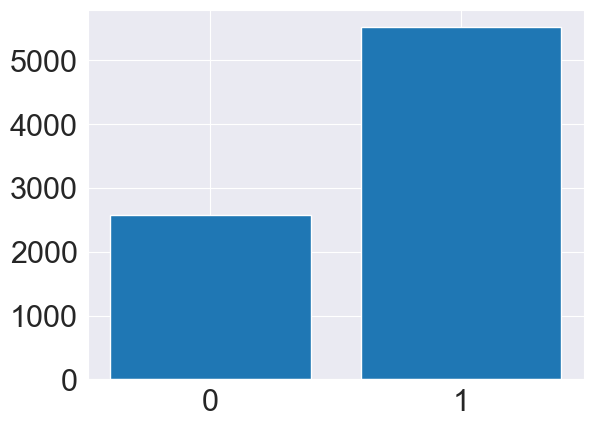

In [93]:
neg, pos = tf.math.bincount(train_labels)

plt.rcParams.update({'font.size': 22})
plt.xticks([0, 1])
plt.bar([0, 1], [neg, pos])
plt.show()

In [94]:
BATCH_SIZE=128

resampled_steps_per_epoch = np.ceil(2.0*pos.numpy()/BATCH_SIZE)
resampled_steps_per_epoch

87.0

In [95]:
# Now to define the network

# Trajectory data
trajectory_input_shape = resampled_features.shape[1:]
units = 100
trajectory_input = Input(shape=trajectory_input_shape)
trajectory_output = LSTM(units)(trajectory_input)

# Category data
category_input = Input(shape=resampled_categories.shape[1:])

# Merge and add dense layer
merge_layer = concatenate([category_input, trajectory_output])
main_output = Dense(units=1,activation="sigmoid")(merge_layer)

# Define the model with two inputs
model = Model(inputs=[trajectory_input, category_input], outputs=[main_output])

In [96]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.BinaryAccuracy(name='accuracy')
]

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [97]:
EPOCHS = 20

resampled_history = model.fit(
    [resampled_features, resampled_categories],
    resampled_labels,
    # These are not real epochs
    steps_per_epoch=resampled_steps_per_epoch,
    epochs=EPOCHS,
    validation_data=([val_data, val_categories], val_labels))

Epoch 1/20
87/87 [==============================] - 3s 18ms/step - loss: 0.5878 - tp: 2845.0000 - fp: 1056.0000 - tn: 4465.0000 - fn: 2676.0000 - accuracy: 0.6620 - val_loss: 0.7959 - val_tp: 1348.0000 - val_fp: 15.0000 - val_tn: 116.0000 - val_fn: 546.0000 - val_accuracy: 0.7230
Epoch 2/20
87/87 [==============================] - 1s 11ms/step - loss: 0.3768 - tp: 4735.0000 - fp: 878.0000 - tn: 4643.0000 - fn: 786.0000 - accuracy: 0.8493 - val_loss: 0.8498 - val_tp: 1189.0000 - val_fp: 15.0000 - val_tn: 116.0000 - val_fn: 705.0000 - val_accuracy: 0.6444
Epoch 3/20
87/87 [==============================] - 1s 11ms/step - loss: 0.3411 - tp: 4750.0000 - fp: 722.0000 - tn: 4799.0000 - fn: 771.0000 - accuracy: 0.8648 - val_loss: 0.8695 - val_tp: 1125.0000 - val_fp: 14.0000 - val_tn: 117.0000 - val_fn: 769.0000 - val_accuracy: 0.6133
Epoch 4/20
87/87 [==============================] - 1s 11ms/step - loss: 0.3257 - tp: 4694.0000 - fp: 627.0000 - tn: 4894.0000 - fn: 827.0000 - accuracy: 0.8683 

In [98]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, metric):
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    # else:
    #   plt.ylim([0.7,1])

    plt.legend()

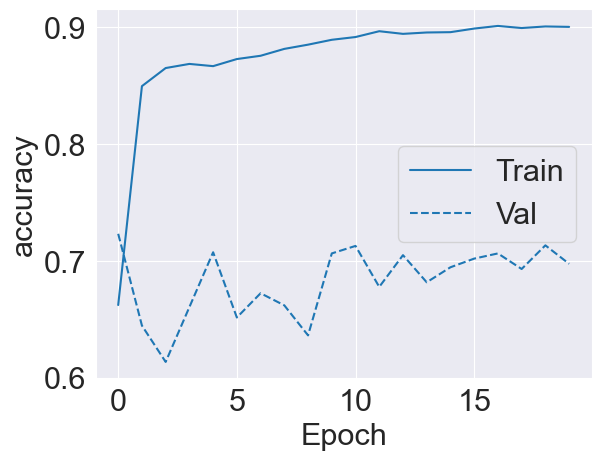

In [99]:
plot_metrics(resampled_history, "accuracy")

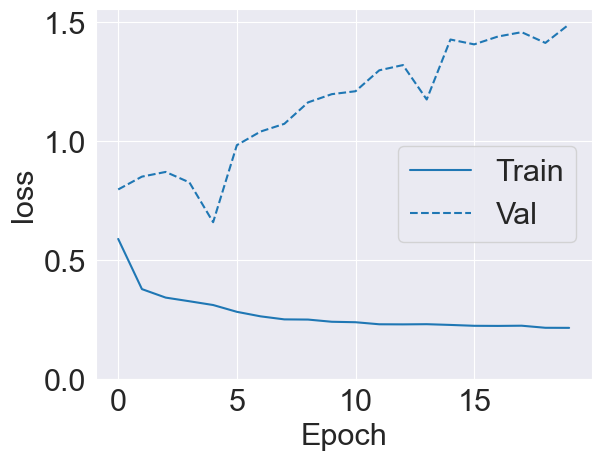

In [100]:
plot_metrics(resampled_history, "loss")

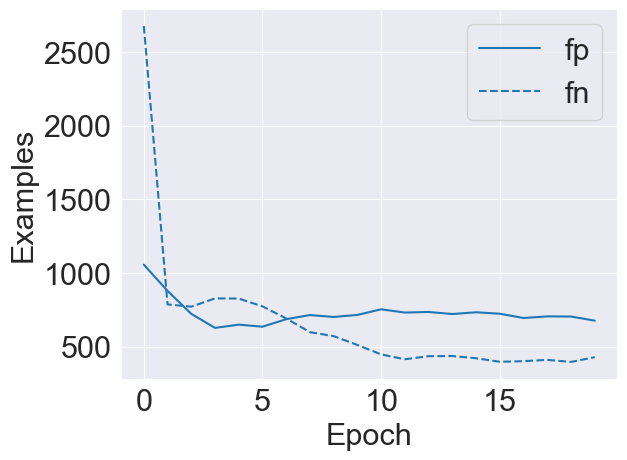

In [101]:
plt.plot(resampled_history.epoch, resampled_history.history['fp'], color=colors[0], label='fp')
plt.plot(resampled_history.epoch, resampled_history.history['fn'], color=colors[0], linestyle="--", label='fn')
plt.xlabel('Epoch')
plt.ylabel('Examples')

plt.legend()

In [102]:
resampled_results = model.evaluate([test_data, test_categories], test_labels, batch_size=BATCH_SIZE, verbose=0)

In [103]:
for name, value in zip(model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

loss :  1.5121212005615234
tp :  1643.0
fp :  60.0
tn :  108.0
fn :  720.0
accuracy :  0.6918213963508606



In [104]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [105]:
test_predictions = model.predict([test_data, test_categories], batch_size=BATCH_SIZE)

20/20 [==============================] - 0s 3ms/step


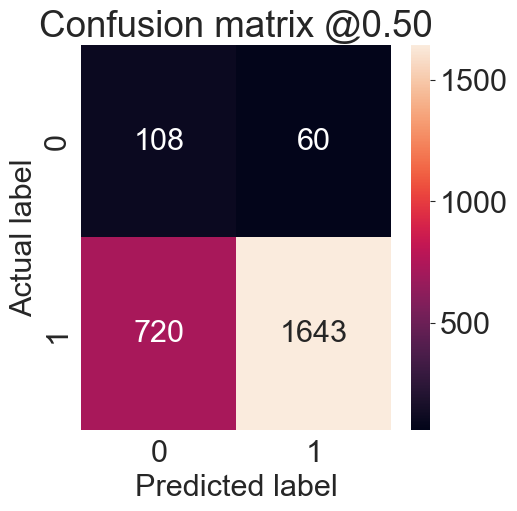

In [106]:
plot_cm(test_labels, test_predictions)